In [7]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
data_path = '/content/drive/My Drive/LPR/Car Localization/car_train_data'
data_path = Path(data_path)

In [12]:
data_path.ls()

[PosixPath('/content/drive/My Drive/LPR/Car Localization/car_train_data/Car'),
 PosixPath('/content/drive/My Drive/LPR/Car Localization/car_train_data/Non-car')]

In [0]:
tfms = get_transforms()

In [0]:
np.random.seed(42)
data = (ImageList.from_folder(data_path)
        .split_by_rand_pct(0.2)
        .label_from_folder()
        .transform(tfms,size=128)
        .databunch()
        .normalize(imagenet_stats)
        )

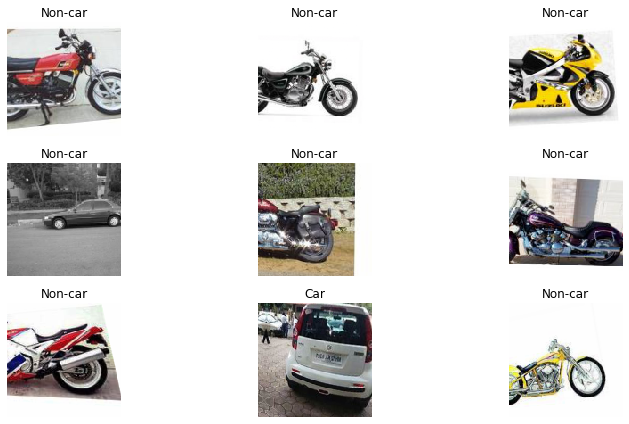

In [15]:
data.show_batch(rows=3,figsize=(12,6))

In [16]:
data.train_ds[0]

(Image (3, 128, 128), Category Car)

In [17]:
data.c,len(data.train_ds),len(data.valid_ds)

(2, 1844, 460)

In [18]:
data.classes

['Car', 'Non-car']

In [19]:
learn = cnn_learner(data,models.resnet34,metrics=[ error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 60.6MB/s]


In [20]:
## Architecture of our Model
learn

Learner(data=ImageDataBunch;

Train: LabelList (1844 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Car,Car,Car,Car,Car
Path: /content/drive/My Drive/LPR/Car Localization/car_train_data;

Valid: LabelList (460 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Non-car,Non-car,Non-car,Car,Non-car
Path: /content/drive/My Drive/LPR/Car Localization/car_train_data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [21]:
learn.fit_one_cycle(4)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idx = interp.top_losses()

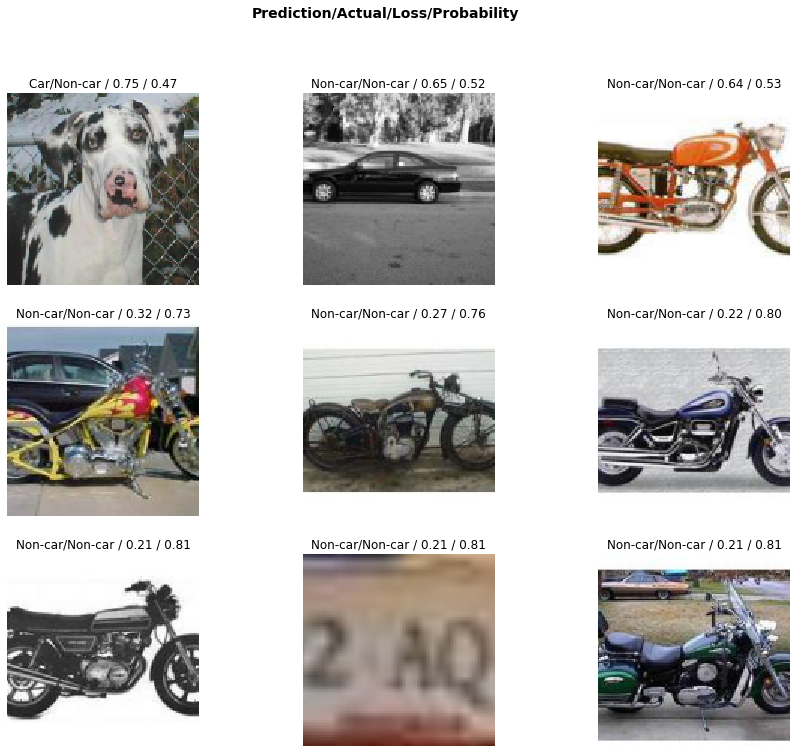

In [25]:
interp.plot_top_losses(9,figsize=(15,12))

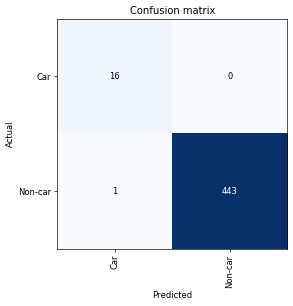

In [26]:
interp.plot_confusion_matrix(figsize=(10,5),dpi=60)

In [27]:
interp.most_confused(min_val=3)

[]

In [0]:
pkl_pth=Path('/content/drive/My Drive/LPR/Car Localization/export.pkl')
learn.export(pkl_pth)

In [33]:
test_imgs = ImageList.from_folder('/content/drive/My Drive/LPR/Car Localization/car_test_data/test')
print(len(test_imgs))

18


In [34]:
pkl_pth.ls

<bound method <lambda> of PosixPath('/content/drive/My Drive/LPR/Car Localization/export.pkl')>

In [0]:
learn = load_learner('/content/drive/My Drive/LPR/Car Localization', test=test_imgs)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [36]:
preds

tensor([[9.3149e-01, 6.8506e-02],
        [1.0000e+00, 5.0657e-09],
        [1.0000e+00, 2.2733e-07],
        [1.0000e+00, 2.9518e-10],
        [1.0000e+00, 1.5698e-11],
        [1.0000e+00, 3.2088e-09],
        [9.9923e-01, 7.7072e-04],
        [9.9099e-01, 9.0119e-03],
        [1.0797e-03, 9.9892e-01],
        [1.0860e-03, 9.9891e-01],
        [1.0000e+00, 2.6652e-10],
        [1.0000e+00, 1.1882e-08],
        [1.0000e+00, 1.3663e-07],
        [1.0826e-02, 9.8917e-01],
        [4.6276e-02, 9.5372e-01],
        [3.9743e-03, 9.9603e-01],
        [3.5204e-02, 9.6480e-01],
        [9.9986e-01, 1.4174e-04]])

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [38]:
labelled_preds[:]

['Car',
 'Car',
 'Car',
 'Car',
 'Car',
 'Car',
 'Car',
 'Car',
 'Non-car',
 'Non-car',
 'Car',
 'Car',
 'Car',
 'Non-car',
 'Non-car',
 'Non-car',
 'Non-car',
 'Car']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [40]:
fnames[:]

['00000001',
 '02287',
 '02888',
 'image_0199',
 'image_0200',
 'z.',
 'x.',
 'y.',
 'Copy of image_0031',
 'Copy of Copy of image_0046',
 'Copy of 00000042',
 'Copy of 00000675',
 'Copy of 02516',
 'image_0002',
 'image_0067',
 'image_0063',
 'image_0004',
 'Copy of 00000000']

In [41]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
df

image_name     tags
0                     00000001      Car
1                        02287      Car
2                        02888      Car
3                   image_0199      Car
4                   image_0200      Car
5                           z.      Car
6                           x.      Car
7                           y.      Car
8           Copy of image_0031  Non-car
9   Copy of Copy of image_0046  Non-car
10            Copy of 00000042      Car
11            Copy of 00000675      Car
12               Copy of 02516      Car
13                  image_0002  Non-car
14                  image_0067  Non-car
15                  image_0063  Non-car
16                  image_0004  Non-car
17            Copy of 00000000      Car

In [42]:
df.head()

image_name tags
0    00000001  Car
1       02287  Car
2       02888  Car
3  image_0199  Car
4  image_0200  Car

In [59]:
image = cv2.imread('/content/drive/My Drive/LPR/Car Localization/car_test_data/test/images.jpeg') # your image path
tmp = image # for drawing a rectangle
d =image.shape
d

(175, 288, 3)

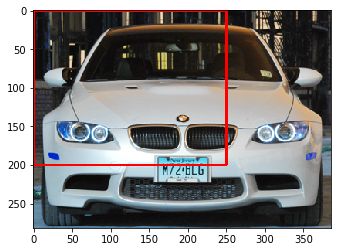

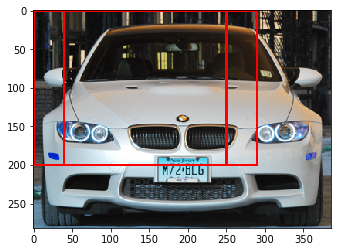

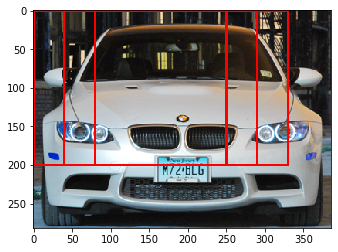

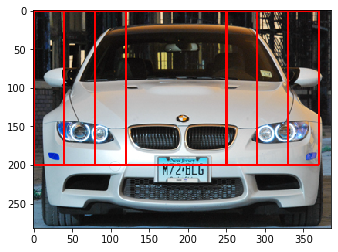

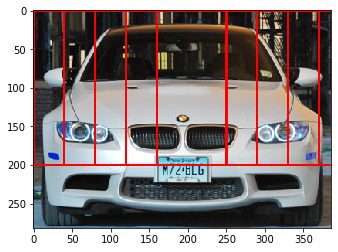

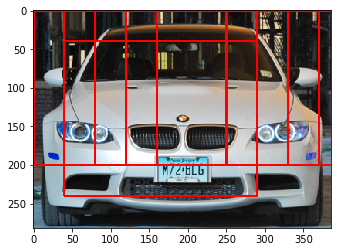

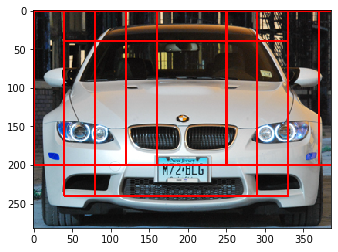

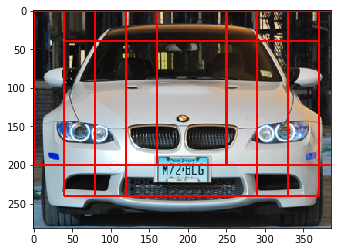

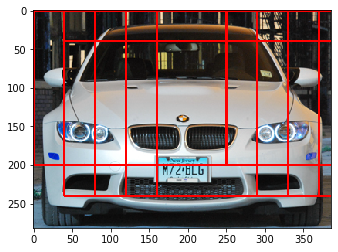

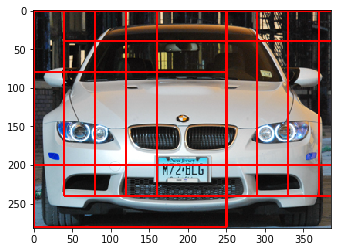

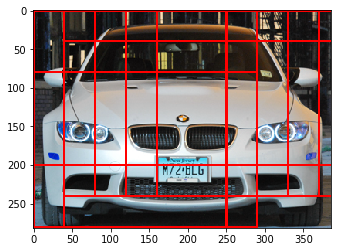

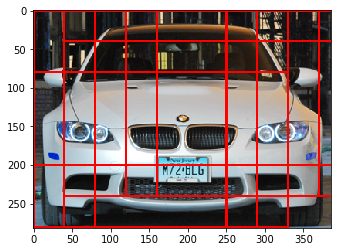

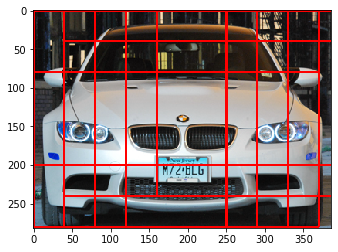

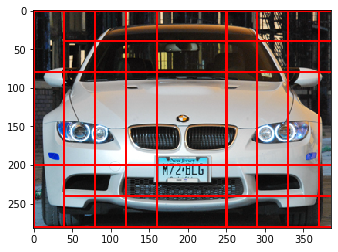

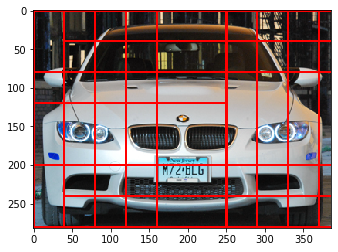

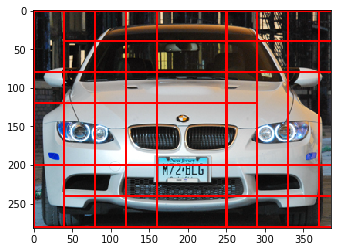

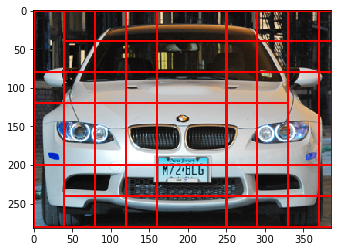

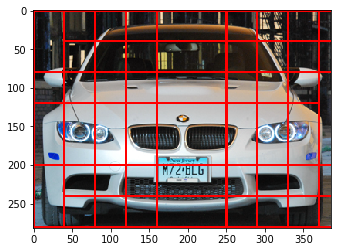

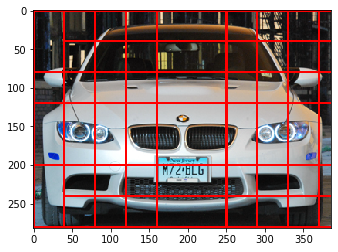

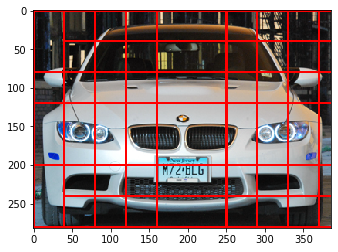

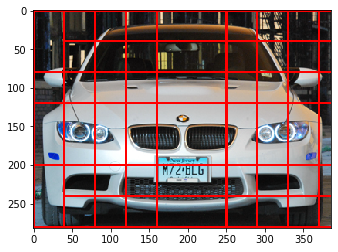

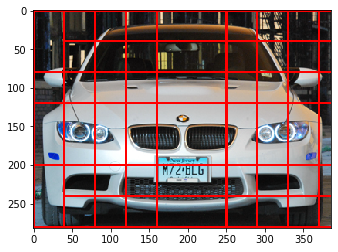

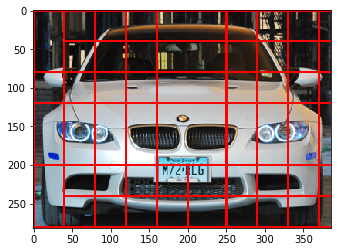

In [92]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# read the image and define the stepSize and window size 
# (width,height)
image = cv2.imread('/content/drive/My Drive/LPR/Car Localization/car_test_data/test/02287.jpg') # your image path
tmp = image # for drawing a rectangle
stepSize = 40
(w_width, w_height) = (250, 200) # window size
for y in range(0, image.shape[0], stepSize):
  for x in range(0, image.shape[1], stepSize):
    window = image[y:y + w_height, x:x + w_width]
    img1 = Image.fromarray(window,'RGB')
    img1.save('check.png')
    img1.show()
#for x in range(0, image.shape[1] - w_width , stepSize):
#   for y in range(0, image.shape[0] - w_height, stepSize):
    img = open_image('check.png')
    pred_class, pref_idx, outputs = learn.predict(img)
    p = str(pred_class)
# classify content of the window with your classifier and  
# determine if the window includes an object (cell) or not

    if p == "Car":
      cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2) # draw rectangle on image
      plt.imshow(np.array(tmp).astype('uint8'))

      # draw window on image

 # show all windows
      plt.show()